#### Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

In [161]:
import numpy as np
import pandas as pd

from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial as sp
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
import shap

from gensim.models import Word2Vec

from datetime import datetime
from collections import defaultdict

C:\Users\Mi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1)

Загрузим юзеров, выкинем странные признаки, посчитаем сколько они зарегестрированы в приложении 

In [59]:
users = pd.read_csv('dataset/members.csv'
                    , dtype={
                        'msno': 'category'
                        , 'bd': 'int'
                        , 'city': 'category'
                        , 'gender': 'category'
                        , 'registration_init_time': str
                        , 'expiration_date': str
                    }
                    , parse_dates=['registration_init_time', 'expiration_date'])

users['time'] = users['expiration_date'] - users['registration_init_time']
users['gender'] = users['gender'].cat.add_categories('-').fillna('-')

users.drop(['registered_via', 'expiration_date', 'registration_init_time'], axis=1, inplace=True)

users.head(2)

,msno,city,bd,gender,time,359,1259,1019,1011,465,...,808,1117,1162,2144,2127,95,2008,1266,1110,2065
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,-,2223 days,0.0,0.007042,0.0,0.007042,2.992188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,-,725 days,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Загрузим песни  
В случае нескольких жанров, оставим первый

In [3]:
types = {
    'song_id': 'category'
    , 'artist_name': 'category'
    , 'composer': 'category'
    , 'language': 'category'
    , 'name': 'category'
    , 'isrc': 'str'
}

info = pd.read_csv('dataset/song_extra_info.csv', dtype=types)
songs = pd.read_csv('dataset/songs.csv', dtype=types).merge(info, how='left')

def take_first(some):
    return some.split('|')[0]

songs['artist_name'] = songs['artist_name'].cat.add_categories('-').fillna('-').agg(take_first)
songs['composer'] = songs['composer'].fillna('-').agg(take_first)
songs['genre'] = songs['genre_ids'].fillna('-').agg(take_first)
songs.drop('lyricist', axis=1, inplace=True)

Раскодируем язык, лейбл и год песни  

In [4]:
def year_to_int(year):
    if year is None:
        return None
    if year > 21:
        return 1900 + year
    return 2000 + year

year_to_int(68), year_to_int(int('08'))

(1968, 2008)

In [61]:
songs['country'] = songs['isrc'].agg(lambda s: str(s)[:2] if str(s).lower() != 'nan' else '-').astype('category')
songs['label'] = songs['isrc'].agg(lambda s: str(s)[2:5] if str(s).lower() != 'nan' else '-').astype('category')
songs['year'] = songs['isrc'].agg(lambda s: int(str(s)[5:7]) if str(s).lower() != 'nan' else None)

songs['year'] = songs['year'].agg(lambda s: year_to_int(s))
songs['year'] = songs['year'].fillna(songs['year'].median()).astype('int')

songs.drop('isrc', axis=1, inplace=True)

songs.head(2)

,song_id,song_length,genre_ids,artist_name,composer,language,name,genre,country,label,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,3.0,焚情,465,TW,B53,2014
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY,31.0,PLAYING WITH FIRE,444,-,-,2011


Всё кроме юзеров склеим в один датасет  
Позволю себе выкинуть песни, про которые нет информации, из-за того что, кто-то в неправильном порядке выгрузил таблицы из базы данных  

In [60]:
df = pd.read_csv('dataset/train.csv', dtype={
    'msno': 'category'
    , 'song_id': 'category'
    , 'source_system_tab': 'category'
    , 'source_screen_name': 'category'
    , 'source_type': 'category'
    , 'target': 'int'}).merge(songs, how='left')

df.drop(['source_system_tab', 'source_screen_name', 'genre_ids'], axis=1, inplace=True)
df['source_type'] = df['source_type'].cat.add_categories('-').fillna('-')

df.dropna(inplace=True)

df.head(2)

,msno,song_id,source_type,target,song_length,artist_name,composer,language,name,genre,...,808,1117,1162,2144,2127,95,2008,1266,1110,2065
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,online-playlist,1,206471.0,Bastille,Dan Smith,52.0,Good Grief,359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,local-playlist,1,284584.0,Various Artists,-,52.0,Lords of Cardboard,1259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Для каждого юзера посчитаем его предпочтения по жанрам

In [ ]:
%%time

u = users['msno'].to_numpy()
msno_to_index = {}
for i in range(len(u)):
    msno_to_index[u[i]] = i
    
g = df[df['target'] == 1]['genre'].unique()
genre_to_index = {}
for i in range(len(g)):
    genre_to_index[g[i]] = i

counts = np.zeros((len(u), len(g)), dtype=np.float16)
    
likes = df[df['target'] == 1][['genre', 'msno']].to_numpy()
for genre, msno in likes:
    msno_index = msno_to_index[msno]
    genre_index = genre_to_index[genre]
    counts[msno_index][genre_index] += 1
    
counts = np.apply_along_axis(lambda a: a / len(a), 1, counts)

for genre in g:
    users[genre] = counts.T[genre_to_index[genre]]
    users[genre] = users[genre].astype(np.float16)
    
users.head(2)

Теперь юзеров можно добавить в основной датасет

In [53]:
df = df.merge(users, how='left')
df.head(2)

,msno,song_id,source_type,target,song_length,artist_name,composer,language,name,genre,...,808,1117,1162,2144,2127,95,2008,1266,1110,2065
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,online-playlist,1,206471.0,Bastille,Dan Smith,52.0,Good Grief,359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,local-playlist,1,284584.0,Various Artists,-,52.0,Lords of Cardboard,1259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Поделим данные

In [9]:
x = df.drop('target', axis=1)
y = df['target']

Не знаю, считается ли это за хороший тюнинг  
Но catboost отлично автоматически настраивает гиперпараметры, если поставить побольше итераций 

In [12]:
%%time
gbdt = cross_validate(CatBoostRegressor(iterations=200
                        , learning_rate=0.5
                        , task_type="CPU"
                        , custom_metric=['AUC:hints=skip_train~false']
                        , cat_features=['msno','song_id','source_type','genre','artist_name','composer'
                                        ,'language','name','country','city','bd','gender','label'])
                    , x, y, cv=ShuffleSplit(n_splits=1, test_size=0.2)
                    , return_estimator=True,return_train_score=True, scoring="roc_auc")

0:	learn: 0.4574468	total: 18s	remaining: 59m 39s
1:	learn: 0.4398068	total: 31.9s	remaining: 52m 35s
2:	learn: 0.4294481	total: 46s	remaining: 50m 23s
3:	learn: 0.4250410	total: 54.9s	remaining: 44m 49s
4:	learn: 0.4238004	total: 1m 5s	remaining: 42m 50s
5:	learn: 0.4225890	total: 1m 17s	remaining: 41m 42s
6:	learn: 0.4215635	total: 1m 31s	remaining: 42m 16s
7:	learn: 0.4210788	total: 1m 45s	remaining: 42m
8:	learn: 0.4200037	total: 2m 2s	remaining: 43m 15s
9:	learn: 0.4195602	total: 2m 14s	remaining: 42m 30s
10:	learn: 0.4192450	total: 2m 26s	remaining: 42m
11:	learn: 0.4185825	total: 2m 42s	remaining: 42m 26s
12:	learn: 0.4181370	total: 2m 56s	remaining: 42m 13s
13:	learn: 0.4177858	total: 3m 9s	remaining: 41m 52s
14:	learn: 0.4173301	total: 3m 20s	remaining: 41m 7s
15:	learn: 0.4169704	total: 3m 32s	remaining: 40m 46s
16:	learn: 0.4167169	total: 3m 46s	remaining: 40m 40s
17:	learn: 0.4165582	total: 3m 57s	remaining: 39m 58s
18:	learn: 0.4162732	total: 4m 8s	remaining: 39m 25s
19:	l

151:	learn: 0.4069323	total: 32m 24s	remaining: 10m 14s
152:	learn: 0.4069063	total: 32m 35s	remaining: 10m
153:	learn: 0.4068794	total: 32m 47s	remaining: 9m 47s
154:	learn: 0.4068681	total: 32m 59s	remaining: 9m 34s
155:	learn: 0.4068483	total: 33m 9s	remaining: 9m 21s
156:	learn: 0.4068265	total: 33m 23s	remaining: 9m 8s
157:	learn: 0.4067448	total: 33m 34s	remaining: 8m 55s
158:	learn: 0.4067170	total: 33m 46s	remaining: 8m 42s
159:	learn: 0.4066661	total: 33m 57s	remaining: 8m 29s
160:	learn: 0.4066420	total: 34m 6s	remaining: 8m 15s
161:	learn: 0.4066087	total: 34m 19s	remaining: 8m 3s
162:	learn: 0.4065858	total: 34m 29s	remaining: 7m 49s
163:	learn: 0.4065410	total: 34m 40s	remaining: 7m 36s
164:	learn: 0.4065274	total: 34m 52s	remaining: 7m 23s
165:	learn: 0.4065090	total: 35m 6s	remaining: 7m 11s
166:	learn: 0.4064820	total: 35m 18s	remaining: 6m 58s
167:	learn: 0.4064282	total: 35m 28s	remaining: 6m 45s
168:	learn: 0.4063904	total: 35m 40s	remaining: 6m 32s
169:	learn: 0.406

In [13]:
gbdt

{'fit_time': array([2793.96203351]),
 'score_time': array([462.37457943]),
 'estimator': (<catboost.core.CatBoostRegressor at 0x1fdc095ef48>,),
 'test_score': array([0.8531347]),
 'train_score': array([0.93453449])}

Немного переобучились, но результаты отличные  
train - 0.93  
test  &nbsp;- 0.85  

#### Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

#### а) показать симилары глазами

Поделим данные

In [15]:
train = df[df['target'] == 1].head(int(len(df) * 0.8))
test = df.tail(int(len(df) * 0.2))

Для w2v посчитаем контексты - что лайкал юзер

In [62]:
contexts = defaultdict(list)

for msno, song_id in train[['msno', 'song_id']].sort_values(by='msno').to_numpy():
    contexts[msno].append(song_id)

In [37]:
%%time
w2v = Word2Vec(contexts.values(), window=10, sg=1, hs=0, vector_size=70, workers=8
               , negative=5, alpha=0.03, min_alpha=0.0007, min_count=10)

Wall time: 1min 5s


Мою музыку не слушают, поэтому будем смотреть на симиларов Lady Gaga

In [71]:
def artists_of_similar_songs(w2v, song_id):
    idx = w2v.wv.key_to_index[song_id]
    similars = w2v.wv.most_similar(idx)
    for sim, _ in similars:
        print(songs[songs['song_id'] == sim]['artist_name'].tolist()[0])

lady_gaga_song_id = 'eW1d3l1sSncU4sGM69MJtIG79wnXbdy8FZKpFVElS0g='        
artists_of_similar_songs(w2v, lady_gaga_song_id)

Lady Gaga
Sia
P!nk
Shawn Mendes
Lukas Graham
gnash
Bruno Mars
Sia
Colbie Caillat
The Chainsmokers


Симилары не слишком радуют, так как всего одна песня того же исполнителя (это не та же самая песня)

#### б) в качестве рекоммендера вместо GBDT (разницу в метриках) 

Будем считать user embedding как среднее песен, которые ему нравятся  
Если для песни нет эмбеддинга, можно взять нулевой вектор, либо среднее по всем эмбеддингам (других идей нет)  
Я возьму нулевой, так как среднее по всем - это что-то около попсы, а если песню почти не слушали, то это вряд ли попса 

In [72]:
%%time

user_embeddings = {}

for msno, song_ids in contexts.items():
    song_embeddings = []
    for song_id in song_ids:
        if song_id in w2v.wv.key_to_index.keys():
            song_embeddings.append(w2v.wv[song_id])
        else:
            song_embeddings.append(np.zeros(70))
    song_embeddings = np.asarray(song_embeddings)
    user_embeddings[msno] = song_embeddings.mean(axis=0) 

Wall time: 7.4 s


Добавим к датасету колонку сходства юзера и песни

In [145]:
%%time

similarities = []
i = 0
for msno, song_id in df[['msno', 'song_id']].to_numpy():
    user_emb = user_embeddings.get(msno, np.zeros(70))
    if song_id in w2v.wv.key_to_index.keys():
        song_emb = w2v.wv[song_id]
    else:
        song_emb = np.zeros(70)
    
    similarities.append(1 - sp.distance.cosine(user_emb, song_emb))
    
df['sim'] = similarities

In [146]:
df['sim'].isnull().mean()

0.15715898902507128

Так как я решил заменять отсутсвующий эмбединг нулевым вектором, в датасете появились Nan'ы 

Заменим их на 0.5

In [152]:
df['sim'] = df['sim'].fillna(0.5)

И, наконец, результаты

In [156]:
train = df.head(int(len(df) * 0.8))
test = df.tail(int(len(df) * 0.2))
roc_auc_score(train['target'], train['sim']), roc_auc_score(test['target'], test['sim'])

(0.6727499595527212, 0.6614018344277947)

Слабее деревяшек, но они и учились в разы дольше  
train - 0.67  
test &nbsp;- 0.66

#### в) стек с GBDT (прирост / отсутствие / почему (советую поизучать SHAP values)

In [157]:
x = df.drop('target', axis=1)
y = df['target']

In [159]:
%%time
gbdt = cross_validate(CatBoostRegressor(iterations=200
                        , learning_rate=0.5
                        , task_type="CPU"
                        , custom_metric=['AUC:hints=skip_train~false']
                        , cat_features=['msno','song_id','source_type','genre','artist_name','composer'
                                        ,'language','name','country','city','bd','gender','label'])
                    , x, y, cv=ShuffleSplit(n_splits=1, test_size=0.2)
                    , return_estimator=True,return_train_score=True, scoring="roc_auc")

0:	learn: 0.4513853	total: 12.2s	remaining: 40m 20s
1:	learn: 0.4333015	total: 25.8s	remaining: 42m 38s
2:	learn: 0.4242601	total: 39.4s	remaining: 43m 7s
3:	learn: 0.4207625	total: 51.9s	remaining: 42m 20s
4:	learn: 0.4189985	total: 1m 4s	remaining: 41m 42s
5:	learn: 0.4180029	total: 1m 18s	remaining: 42m 15s
6:	learn: 0.4159098	total: 1m 29s	remaining: 41m 4s
7:	learn: 0.4144353	total: 1m 45s	remaining: 42m 4s
8:	learn: 0.4139456	total: 1m 56s	remaining: 41m 12s
9:	learn: 0.4131914	total: 2m 15s	remaining: 43m 2s
10:	learn: 0.4119285	total: 2m 28s	remaining: 42m 39s
11:	learn: 0.4116021	total: 2m 39s	remaining: 41m 39s
12:	learn: 0.4110713	total: 2m 55s	remaining: 41m 58s
13:	learn: 0.4107800	total: 3m 6s	remaining: 41m 19s
14:	learn: 0.4102599	total: 3m 21s	remaining: 41m 23s
15:	learn: 0.4099392	total: 3m 31s	remaining: 40m 33s
16:	learn: 0.4095937	total: 3m 41s	remaining: 39m 42s
17:	learn: 0.4093238	total: 3m 53s	remaining: 39m 20s
18:	learn: 0.4089092	total: 4m 8s	remaining: 39m

151:	learn: 0.4000214	total: 31m 56s	remaining: 10m 5s
152:	learn: 0.3999997	total: 32m 7s	remaining: 9m 52s
153:	learn: 0.3999898	total: 32m 18s	remaining: 9m 39s
154:	learn: 0.3999496	total: 32m 32s	remaining: 9m 26s
155:	learn: 0.3999326	total: 32m 43s	remaining: 9m 13s
156:	learn: 0.3999103	total: 32m 57s	remaining: 9m 1s
157:	learn: 0.3998955	total: 33m 7s	remaining: 8m 48s
158:	learn: 0.3998767	total: 33m 21s	remaining: 8m 36s
159:	learn: 0.3998521	total: 33m 39s	remaining: 8m 24s
160:	learn: 0.3998211	total: 33m 51s	remaining: 8m 12s
161:	learn: 0.3998062	total: 34m 6s	remaining: 8m
162:	learn: 0.3997613	total: 34m 19s	remaining: 7m 47s
163:	learn: 0.3997246	total: 34m 33s	remaining: 7m 35s
164:	learn: 0.3997037	total: 34m 45s	remaining: 7m 22s
165:	learn: 0.3996252	total: 34m 57s	remaining: 7m 9s
166:	learn: 0.3995912	total: 35m 13s	remaining: 6m 57s
167:	learn: 0.3995729	total: 35m 29s	remaining: 6m 45s
168:	learn: 0.3995480	total: 35m 45s	remaining: 6m 33s
169:	learn: 0.39952

In [160]:
gbdt

{'fit_time': array([2876.85455632]),
 'score_time': array([64.7890501]),
 'estimator': (<catboost.core.CatBoostRegressor at 0x1fd85117148>,),
 'test_score': array([0.86127017]),
 'train_score': array([0.93644494])}

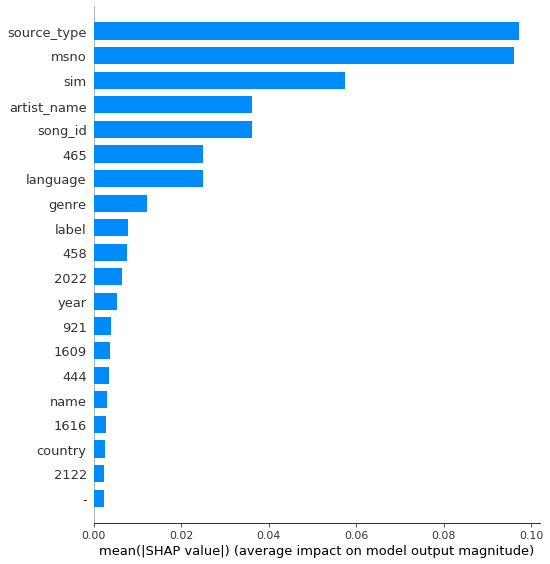

In [165]:
explainer = shap.TreeExplainer(gbdt['estimator'][0])
shap_values = explainer.shap_values(x[:10_000])
shap.summary_plot(shap_values, x[:10_000], plot_type="bar")

Мы знатно переобучились и в первый, и во второй раз  
Но радует, что деревья дружат с w2v